In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline

# Problem 2

In [3]:
n = 120
mu = 0.07
sigma_x = 0.02
sigma_eps = 0.14
gamma = 3

def sim_1path(plot=False):
    sample = np.random.multivariate_normal(
        np.array([0, 0]),
        np.array([[sigma_x**2, 0],[0, sigma_eps**2]]),
        size=n
    )
    x, eps = sample[:, 0], sample[:, 1]
    r = mu + x + eps
    w_mkt_timing = (1/gamma) * (mu + x)/(sigma_eps**2)
    w_balanced = (1/gamma) * mu/(sigma_x**2 + sigma_eps**2)
    rp_mkt_timing = r*w_mkt_timing
    rp_balanced = r*w_balanced
    wealth_mkt_timing = np.cumprod(1+rp_mkt_timing)
    wealth_balanced = np.cumprod(1+rp_balanced)
    if plot:
        fig, axes = plt.subplots(2,1,figsize=(8,8),sharex='all')
        axes[0].plot(w_mkt_timing, color='blue',label='Market Timing')
        axes[0].plot([w_balanced]*n, color='red',label='Balanced')
        axes[0].set_title('Weights')
        axes[0].set_ylabel('Weights')
        axes[1].plot(wealth_mkt_timing, color='blue')
        axes[1].plot(wealth_balanced, color='red')
        axes[1].set_title('Wealth Path')
        axes[1].set_xlabel('Periods')
        axes[1].set_ylabel('Wealth')
        axes[0].legend()
    return wealth_mkt_timing[-1], wealth_balanced[-1]

(9195.4619474024312, 3856.9514328138243)

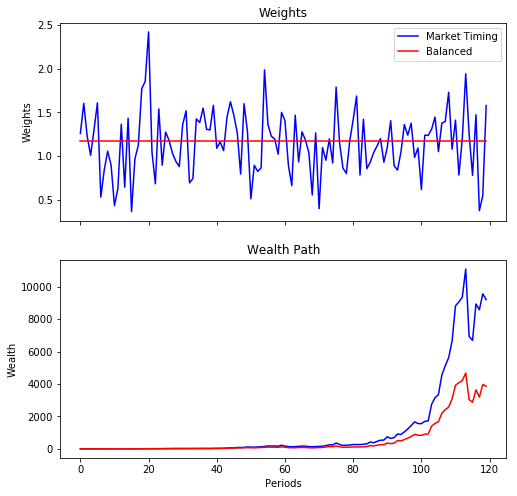

In [119]:
sim_1path(plot=True)

In [148]:
sample = []
from progressbar import ProgressBar
bar = ProgressBar()
for _ in bar(range(30000)):
    r1, r2 = sim_1path(plot=False)
    sample.append([r1, r2])
sample = np.array(sample)
sample.mean(axis=0)

100% (30000 of 30000) |###################| Elapsed Time: 0:00:05 Time: 0:00:05


array([ 31703.62661888,  12368.82899717])

In [137]:
S = mu/np.sqrt(sigma_eps**2 + sigma_x**2)
R = np.sqrt(sigma_x**2 / (sigma_eps**2 + sigma_x**2))
r_expected_mkt_timing = (1/gamma) * (S**2 + R**2) / (1-R**2)
r_expected_balanced = S**2/gamma
r_expected_mkt_timing, r_expected_balanced

(0.090136054421768697, 0.081666666666666651)

In [138]:
(1+r_expected_mkt_timing)**120, (1+r_expected_balanced)**120

(31454.617844235298, 12337.113778282106)

# Problem 3

## (a)

In [4]:
snp_mth = pd.read_csv('snp_monthly.csv', index_col=0)
snp_mth['r_risky'] = snp_mth['Index'].pct_change()
snp_mth['r_ex'] = snp_mth['r_risky'] - snp_mth['Rfree'].shift(1)
snp_tr = snp_mth.loc[:198012,:]
snp_tr = snp_tr.dropna()
mu, sigma = snp_tr['r_ex'].mean(), snp_tr['r_ex'].std()
mu, sigma

(0.0006074165442569224, 0.042354897973618945)

In [5]:
w_opt_meanvar = (1/gamma) * (mu/sigma**2)
w_opt_meanvar

0.11286468714593713

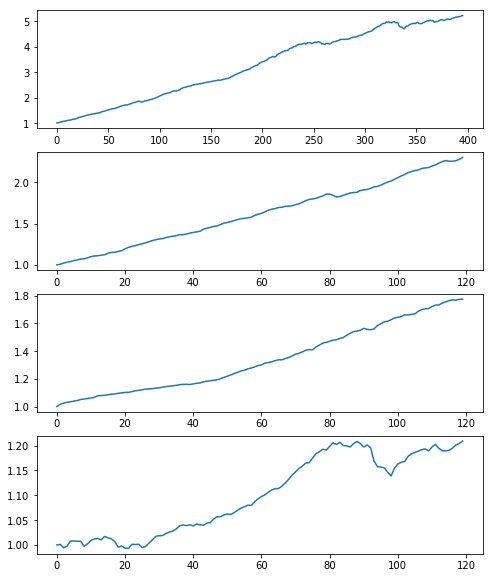

In [9]:
tests = [
    snp_mth.loc[198101:201312,:],
    snp_mth.loc[198101:199012,:],
    snp_mth.loc[199101:200012,:],
    snp_mth.loc[200101:201012,:]
]
fig, axes = plt.subplots(4,1,figsize=(8,10))
for i, snp_te in enumerate(tests):
    rf = snp_te['Rfree'].shift(1).values
    rex = snp_te['Index'].pct_change().fillna(0).values - rf
    raw_ret = 1 + rf + w_opt_meanvar*rex
    raw_ret[0] = 1
    axes[i].plot(np.cumprod(raw_ret))

## (b)

In [12]:
snp_qtr = pd.read_csv('snp_quarterly.csv', index_col=0)
snp_anl = pd.read_csv('snp_annual.csv', index_col=0)
data = [snp_mth, snp_qtr, snp_anl]
for d in data:
    d['dpr'] = d['dividend']/d['Index']
    d['dpr_lag'] = d['dpr'].shift(1)
    d['r_ex'] = d['Index'].pct_change() - d['Rfree'].shift(1)
    snp_in = d.dropna(subset=['r_ex', 'dpr_lag'])
    # print(snp_in.index[0], snp_in.index[-1])
    model = sm.OLS(
        snp_in['r_ex'].values, 
        sm.add_constant(snp_in[['dpr_lag']].values)
    )
    results = model.fit()
    print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5555
Date:                Tue, 30 Oct 2018   Prob (F-statistic):              0.456
Time:                        23:23:02   Log-Likelihood:                 3142.3
No. Observations:                1763   AIC:                            -6281.
Df Residuals:                    1761   BIC:                            -6270.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.003      1.236      0.2

## (c)

In [13]:
ts = list(snp_mth.loc[198012:,:].index)
preds = []
means = []
for i, t in enumerate(ts):
    tr = snp_mth.loc[:t,:]
    snp_in = tr.dropna(subset=['r_ex', 'dpr_lag'])
    X = sm.add_constant(snp_in[['dpr_lag']].values)
    model = sm.OLS(
        snp_in['r_ex'].values, X
    )
    results = model.fit()
    a, b = results.params
    if i != (len(ts)-1):
        pred = a + b*snp_mth.loc[ts[i+1], 'dpr_lag']
        preds.append(pred)
        means.append(snp_in['r_ex'].mean())

In [14]:
te = snp_mth.loc[198102:,:]
r = te['r_ex'].values
R_oos = 1 - ((r-preds[1:])**2).sum() / ((r-means[1:])**2).sum()
R_oos

4.2657276222435314e-05

## (d)

In [15]:
ts = list(snp_mth.loc[198012:,:].index)
preds = []
means = []
for i, t in enumerate(ts):
    tr = snp_mth.loc[:t,:]
    snp_in = tr.dropna(subset=['r_ex', 'dpr_lag'])
    X = sm.add_constant(snp_in[['dpr_lag']].values)
    model = sm.OLS(
        snp_in['r_ex'].values, X
    )
    results = model.fit()
    a, b = results.params
    if a < 0: a = 0
    if b > 0: b = 0
    if i != (len(ts)-1):
        pred = max(a + b*snp_mth.loc[ts[i+1], 'dpr_lag'], 0)
        preds.append(pred)
        means.append(snp_in['r_ex'].mean())

In [16]:
te = snp_mth.loc[198102:,:]
r = te['r_ex'].values
R_oos = 1 - ((r-preds[1:])**2).sum() / ((r-means[1:])**2).sum()
R_oos

-0.00062685117320127048

## (e)

In [84]:
snp_mth['r_ex_hat'] = np.nan
snp_mth['sigma_eps_hat'] = np.nan
ts = list(snp_mth.index)
for i, t in enumerate(ts):
    if t <= 198012:
        continue # accumulate training data until 198012
    if t == 198101 or i%1000 == 0:
        # refit
        snp_tr = snp_mth.loc[:t,:]
        snp_in = snp_tr.dropna(subset=['r_ex', 'dpr_lag'])
        holdfit = sm.OLS(
            snp_in['r_ex'].values, 
            sm.add_constant(snp_in[['dpr_lag']].values)
        ).fit()
        a, b = holdfit.params
    if i < len(ts)-1:
        snp_mth.loc[ts[i+1], 'r_ex_hat'] = a + b*snp_mth.loc[t, 'dpr']
        snp_mth.loc[ts[i+1], 'sigma_eps_hat'] = np.sqrt(
            results.ssr/results.df_resid)
        
snp_mth['w_mkt_timing'] = (1/gamma) * (
    snp_mth['r_ex_hat']) / (snp_mth['sigma_eps_hat']**2)

Sharpe (Constant Weight): 0.3271       Sharpe (Shrinkage): 0.3226
Sharpe (Constant Weight): 0.1217       Sharpe (Shrinkage): 0.1274
Sharpe (Constant Weight): 0.9831       Sharpe (Shrinkage): 1.0320
Sharpe (Constant Weight): -0.1143       Sharpe (Shrinkage): -0.0862


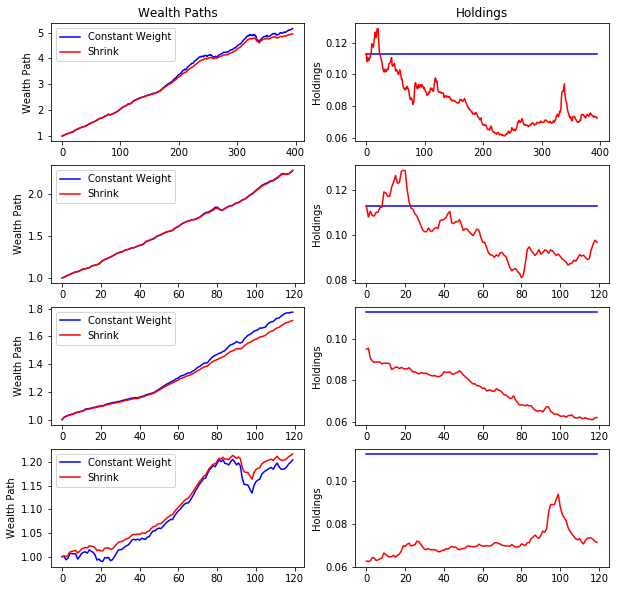

In [102]:
tests = [
    snp_mth.loc[198101:201312,:],
    snp_mth.loc[198101:199012,:],
    snp_mth.loc[199101:200012,:],
    snp_mth.loc[200101:201012,:]
]
fig, axes = plt.subplots(4,2,figsize=(10,10))
for i, snp_te in enumerate(tests):
    w_mkt_timing = snp_te['w_mkt_timing'].fillna(w_opt_meanvar)
    w_shrink = w_mkt_timing.values.clip(
        -w_opt_meanvar, 2*w_opt_meanvar)*0.4 + w_opt_meanvar*0.6
    rf = snp_te['Rfree'].values
    rex = snp_te['r_ex'].values
    rp = rf + w_opt_meanvar*rex
    raw_ret = 1 + rp
    raw_ret[0] = 1 
    rp_shrink = rf + w_shrink*rex
    raw_ret_shrink = 1 + rp_shrink
    raw_ret_shrink[0] = 1
    axes[i,0].plot(np.cumprod(raw_ret), color='blue', label='Constant Weight')
    axes[i,0].plot(np.cumprod(raw_ret_shrink), color='red', label='Shrink')
    axes[i,1].plot([w_opt_meanvar]*len(rp), color='blue')
    axes[i,1].plot(w_shrink, color='red')
    axes[i,0].set_ylabel('Wealth Path')
    axes[i,1].set_ylabel('Holdings')
    axes[i,0].legend()
    s1 = np.sqrt(12)*(w_opt_meanvar*rex).mean()/(w_opt_meanvar*rex).std()
    s2 = np.sqrt(12)*(w_shrink*rex).mean()/(w_shrink*rex).std()
    print(
        f'Sharpe (Constant Weight): {s1:.4f}      ', 
        f'Sharpe (Shrinkage): {s2:.4f}', 
    )
axes[0,0].set_title('Wealth Paths')
_ = axes[0,1].set_title('Holdings')